# COVID19 Tweets EDA

- using data from Sun March 15 - Sat March 21

In [1]:
import gzip, os, re
import json
from datetime import datetime
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
print(os.getcwd())

/Users/mashabelyi/UCBerkeley/courses/Spring_2020/InfoViz/project/notebooks


In [4]:
tweets = pd.read_csv('../data/tweets.0308-0314.csv', error_bad_lines=False, index_col=False)
# tweets = pd.read_csv('../scripts/tweets.0301-0331.usa.csv', error_bad_lines=False, index_col=False)
print(tweets.shape)
tweets.head()

b'Skipping line 19142: expected 25 fields, saw 36\n'
b'Skipping line 400855: expected 25 fields, saw 36\n'
b'Skipping line 448810: expected 25 fields, saw 36\n'


(550608, 25)


,tweetId,lang,userId,user_screen_name,year,month,date,day,hour,minute,...,urls,emojis,sentiment,retweet_cont,favorite_count,lat,long,user_location,place_name,place_bbox
0,1236758588439375872,en,2723456510,TinfoilTricorn,2020,3,8,6,21,0,...,NaN,NaN,-0.0931,0,1,NaN,NaN,Valley Forge; PA,NaN,NaN
1,1236758588653215745,en,470373280,ThinkingKlearly,2020,3,8,6,21,0,...,salon.com,NaN,-0.4019,0,0,NaN,NaN,End the Drug War,NaN,NaN
2,1236758588762267648,en,28821344,wassimz,2020,3,8,6,21,0,...,NaN,NaN,0.3182,0,0,NaN,NaN,Beirut,NaN,NaN
3,1236758591115153408,en,24209167,JoshShapiroPA,2020,3,8,6,21,0,...,NaN,NaN,0.8316,15,35,NaN,NaN,Pennsylvania; USA,NaN,NaN
4,1236758591329177603,en,16950863,KRLD,2020,3,8,6,21,0,...,krld.radio.com,NaN,0.0000,0,1,NaN,NaN,Dallas; TX,NaN,NaN


**Check number of NaNs in each column**

In [9]:
100*(tweets.shape[0]-tweets.isna().sum())/tweets.shape[0]

tweetId             100.000000
lang                100.000000
userId              100.000000
user_screen_name    100.000000
year                100.000000
month               100.000000
date                100.000000
day                 100.000000
hour                100.000000
minute              100.000000
utc_offset          100.000000
text                 99.804035
hashtags             26.161625
user_mentions        42.786520
symbols               0.207225
urls                 36.335832
emojis                9.883620
sentiment           100.000000
retweet_cont        100.000000
favorite_count      100.000000
lat                   0.129675
long                  0.129675
user_location        71.687480
place_name            3.156511
place_bbox            3.156511
dtype: float64

**Check column types**

In [156]:
tweets.dtypes

tweetId               int64
lang                 object
userId                int64
user_screen_name     object
year                  int64
month                 int64
date                  int64
day                   int64
hour                  int64
minute                int64
utc_offset           object
text                 object
hashtags             object
user_mentions        object
symbols              object
urls                 object
emojis               object
sentiment           float64
retweet_cont          int64
favorite_count        int64
lat                 float64
long                float64
user_location        object
place_name           object
place_bbox           object
dtype: object

**<span style="color:red">WARNING! Note that sentiment=0.0 when text is NaN. Remember to remove rows where text is NaN from any sentiment analysis!</span>**

In [157]:
tweets[tweets.text.isna()][['text', 'sentiment']].head()

,text,sentiment
321,NaN,0.0
821,NaN,0.0
992,NaN,0.0
2051,NaN,0.0
3847,NaN,0.0


## Hashtags - Usage over Time

In [160]:
hashtags = [x.split() for x in tweets.hashtags if type(x)==str]
hashtag_counter = Counter()
for tags in hashtags:
    for tag in tags:
        hashtag_counter[tag.lower()] += 1
        
print("{} unique hashtags in {} tweets".format(len(hashtag_counter), len(hashtags)))
print("Top hashtags:")
hashtag_counter.most_common(10)

54137 unique hashtags in 144048 tweets
Top hashtags:


[('coronavirus', 66606),
 ('covid19', 38008),
 ('covidー19', 7650),
 ('corona', 4402),
 ('covid2019', 3992),
 ('coronavirusoutbreak', 3924),
 ('covid', 3456),
 ('covid_19', 3432),
 ('coronavirusupdate', 3091),
 ('china', 2771)]

Count how many times each hashtag is used every day. This takes a little bit longer to run.

In [161]:
hashtag_by_date = defaultdict(lambda: defaultdict(int))
for idx, row in tweets[~tweets.hashtags.isnull()].iterrows():
    date = row['date']
    tags = row['hashtags'].split()
    for t in tags:
        hashtag_by_date[t][date] += 1
    

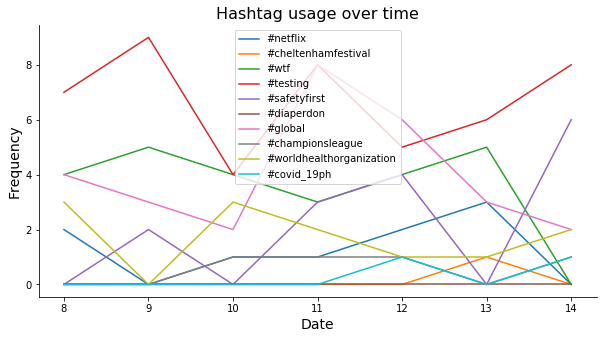

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Hashtag usage over time', fontsize=16)

# dates = [15,16,17,18,19,20,21]
dates = np.arange(8,15)
labels = []
for tag, freq in hashtag_counter.most_common()[500:510]:
    counts = [hashtag_by_date[tag][date] for date in dates]
    labels.append('#'+tag)
#     print(tag, dates, counts)
    ax.plot(dates, counts)

ax.legend(labels)
plt.show()
    
    
    

## Sentiment Analysis

[VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)

Do NOT use the nltk built-in version of Vader. It doesn't hndle punctuation and emojis well (see below).

Instead install vaderSentiment directly with 
```
pip install vaderSentiment
```

In [79]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [66]:
print("vaderSentiment:")
print(analyser.polarity_scores('I am 😄  today'))
print(analyser.polarity_scores('This is so exciting!!!!'))

print('\nltk:')
print(sent.polarity_scores('I am 😄  today'))
print(sent.polarity_scores('This is so exciting!!!!'))

vaderSentiment:
{'neg': 0.0, 'neu': 0.522, 'pos': 0.478, 'compound': 0.6705}
{'neg': 0.0, 'neu': 0.362, 'pos': 0.638, 'compound': 0.7418}

ltk:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Create a new `sentiment` column with the compound score returned from the VADER Sentiment Analyzer tool.

In [67]:
def get_sentiment(row):
    try:
        return analyser.polarity_scores(row['text'])['compound']
    except:
        # if text is nan -> return nan
        return np.nan

tweets['sentiment'] = tweets.apply(lambda row: get_sentiment(row), axis=1)

Count number of positive, negative, neutral tweets by date

In [179]:
def sentiment_cat(v):
    if v > 0.1:
        return 'positive'
    elif v < -0.1:
        return 'negatvie'
    else:
        return 'neutral'
    
sentiment_by_day = defaultdict(lambda: defaultdict(int))
for idx, row in tweets[~tweets.text.isnull()].iterrows():
    date = row['date']
    sentiment = row['sentiment']
    sentiment_by_day[date][sentiment_cat(sentiment)] += 1

In [180]:
totals = {d:sum(sentiment_by_day[d].values()) for d in sentiment_by_day}
totals

{8: 88083, 12: 74074, 10: 81460, 11: 86624, 13: 66787, 9: 92789, 14: 59712}

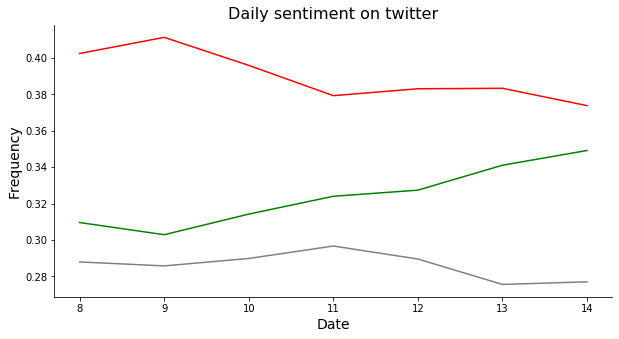

In [182]:
# dates = [15,16,17,18,19,20]
dates = sorted(sentiment_by_day.keys())
pos = [1.0*sentiment_by_day[d]['positive']/totals[d] for d in dates]
neg = [1.0*sentiment_by_day[d]['negatvie']/totals[d] for d in dates]
neu = [1.0*sentiment_by_day[d]['neutral']/totals[d] for d in dates]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Daily sentiment on twitter', fontsize=16)

plt.plot(dates, pos, 'g')
plt.plot(dates, neg, 'r')
plt.plot(dates, neu, 'grey')

plt.show()

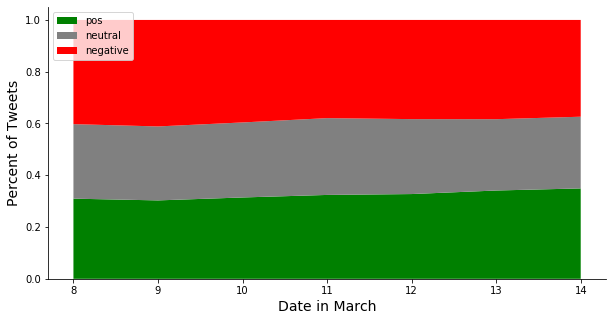

In [183]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.stackplot(dates,[pos, neu,neg], labels=['pos','neutral','negative'], colors=['g', 'grey', 'r'])
ax.legend(loc='upper left')
ax.set_xlabel('Date in March', fontsize=14)
ax.set_ylabel('Percent of Tweets', fontsize=14)
plt.show()


In [91]:
tweet_text = tweets.text.values
for i in range(10):
    print('\n',tweet_text[i])
    print(analyser.polarity_scores(tweet_text[i]))
    


 We stand by Italy during these trying times. Share your Support for our Italian friends  They are our colleagues  friends and family. Cari amici  siamo con voi. #COVID19 #WeStandWithItaly
{'neg': 0.0, 'neu': 0.693, 'pos': 0.307, 'compound': 0.8779}

 Visual art students from Art 350 intermediate painting zooms in to talk about their future project with a lot of modifications due to lack of supplies. Most of these students heavily relied on campus resources like the woodshop in the Visual Arts building. #covid19
{'neg': 0.049, 'neu': 0.897, 'pos': 0.053, 'compound': 0.0516}

 University of Virginia : Request To Make UVA Spring 2020 Classes Pass/Fail An Option Due to COVID-19 - Sign the Petition!
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

 What’s this lot gonna do when everyone has coronavirus #EastEnders
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

 Find city news  updates on services  facilities  schedule changes  COVID-19 information  important numbers and more

## Location

- do we have enough tweets with location specified? Can we map location names to geo coordinates

In [188]:
tweets.shape

(550608, 25)

In [193]:
print("Percent null entries")
100*tweets.isna().sum()/tweets.shape[0]

Percent null entries


tweetId              0.000000
lang                 0.000000
userId               0.000000
user_screen_name     0.000000
year                 0.000000
month                0.000000
date                 0.000000
day                  0.000000
hour                 0.000000
minute               0.000000
utc_offset           0.000000
text                 0.195965
hashtags            73.838375
user_mentions       57.213480
symbols             99.792775
urls                63.664168
emojis              90.116380
sentiment            0.000000
retweet_cont         0.000000
favorite_count       0.000000
lat                 99.870325
long                99.870325
user_location       28.312520
place_name          96.843489
place_bbox          96.843489
dtype: float64

In [245]:
import re
match_str = '({})(.*)'.format('|'.join(us_states))
print(match_str)
re.match(match_str, 'ma')

[connecticut|missouri|oregon|ok|wisconsin|ut|pa|nevada|arizona|id|south carolina|alaska|minnesota|wyoming|nd|ky|mt|tx|wv|vermont|ks|mo|ri|pennsylvaniarhode island|louisiana|maryland|mi|wy|ct|north dakota|de|nh|maine|il|ny|ohio|sc|nj|mississippi|co|al|ne|fl|new jersey|sd|illinoisindiana|delaware|alabama|montananebraska|wi|ga|iowa|ms|massachusetts|virginia|arkansas|la|oklahoma|tennessee|nc|colorado|north carolina|washington|ia|mn|va|in|oh|south dakota|ma|west virginia|ca|utah|michigan|me|idaho|nv|california|florida|new mexico|kansas|hi|texas|nm|md|ar|new york|ak|kentucky|hawaii|az|wa|vt|or|new hampshire|georgia|tn]


<_sre.SRE_Match object; span=(0, 1), match='m'>

In [282]:
res = re.search(r'\b({})\b'.format('|'.join(us_states)), 'East Millcreek; Utah🇺🇸', flags=re.IGNORECASE)
res == None
print(res[1])

Utah


In [451]:
import json
def load_us_cities():
    with open('us_state_cities.json', 'r') as f:
        state_cities = json.load(f)
    return state_cities
# load state:[cities] json
state_cities = load_us_cities()
# map each city to its state
city2state = {city.lower():state.lower() for state in state_cities for city in state_cities[state]}
# get just a list of cities
us_cities = [x.lower() for state, cities in state_cities.items() for x in cities ]

# load us state abbreviations
with open('us_states.json', 'r') as f:
    data = json.load(f)
    state2code = {v.lower():k for k,v in data.items()}
    
# load list of countries
with open('countries.txt', 'r') as f:
    countries = []
    for line in f:
        countries.append(line.strip())

In [544]:
s = ''
if s:
    print('ye')


In [452]:
# check that it works
state2code[city2state['boston']]

'MA'

In [454]:
state2code

{'alabama': 'AL',
 'alaska': 'AK',
 'american samoa': 'AS',
 'arizona': 'AZ',
 'arkansas': 'AR',
 'california': 'CA',
 'colorado': 'CO',
 'connecticut': 'CT',
 'delaware': 'DE',
 'district of columbia': 'DC',
 'federated states of micronesia': 'FM',
 'florida': 'FL',
 'georgia': 'GA',
 'guam': 'GU',
 'hawaii': 'HI',
 'idaho': 'ID',
 'illinois': 'IL',
 'indiana': 'IN',
 'iowa': 'IA',
 'kansas': 'KS',
 'kentucky': 'KY',
 'louisiana': 'LA',
 'maine': 'ME',
 'marshall islands': 'MH',
 'maryland': 'MD',
 'massachusetts': 'MA',
 'michigan': 'MI',
 'minnesota': 'MN',
 'mississippi': 'MS',
 'missouri': 'MO',
 'montana': 'MT',
 'nebraska': 'NE',
 'nevada': 'NV',
 'new hampshire': 'NH',
 'new jersey': 'NJ',
 'new mexico': 'NM',
 'new york': 'NY',
 'north carolina': 'NC',
 'north dakota': 'ND',
 'northern mariana islands': 'MP',
 'ohio': 'OH',
 'oklahoma': 'OK',
 'oregon': 'OR',
 'palau': 'PW',
 'pennsylvania': 'PA',
 'puerto rico': 'PR',
 'rhode island': 'RI',
 'south carolina': 'SC',
 'south da

In [455]:
state_codes = ['AL','AK','AZ','AR','CA','CO','CT','DE', 'DC', 'FL',
             'GA','HI','ID','IL','IN','IA','KS','KY','LA',
             'ME','MD','MA','MI','MN','MS','MO','MT','NE',
             'NV','NH','NJ','NM','NY','NC','ND','OH','OK',
             'OR','PA','RI','SC','SD','TN','TX','UT','VT',
             'VA','WA','WV','WI','WY']
state_names = ['Alabama','Alaska',
             'Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia',
             'Hawaii','Idaho','Illinois', 'Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland',
             'Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana', 'Nebraska','Nevada',
             'New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota',
             'Ohio','Oklahoma','Oregon','Pennsylvania', 'Rhode Island','South Carolina','South Dakota',
             'Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

# state_codes = [s.lower() for s in state_codes]
# state_names = [s.lower() for s in state_names]

unresolved = Counter()
def get_state(row):
    try:
        # state codes
        res = re.search(r'\b({})\b'.format('|'.join(state_codes)), row['user_location'], flags=re.IGNORECASE)
        if res:
            return res[0].upper()
        
        # state names
        res = re.search(r'\b({})\b'.format('|'.join(state_names)), row['user_location'], flags=re.IGNORECASE)
        if res:
            return state2code[res[0].lower()] # convert to state code (CA, MA, IL,...)
        
        # check cities
        res_city = re.search(r'\b({})\b'.format('|'.join(us_cities)), row['user_location'], flags=re.IGNORECASE)
        if res_city:
            return state2code[city2state[res_city[0].lower()]] # convert to state code (CA, MA, IL,...)
        
        # check countries
        res = re.search(r'\b({})\b'.format('|'.join(countries)), row['user_location'], flags=re.IGNORECASE)
        if res:
            return res[0].lower()
        
        unresolved[row['user_location'].lower()] += 1
        return np.nan

    except:
        unresolved[row['user_location']] += 1
        # if text is nan -> return nan
        return np.nan

states = tweets.apply(lambda row: get_state(row), axis=1)

In [456]:
print(f"{len(states)} total tweets")
print(f"{len(unresolved)} unresolved locations")
print(f"{len(states.unique())} unique location names")
print("{} ({:.2%}) tweets with null locations".format(states.isna().sum(), states.isna().sum()/tweets.shape[0]))
print()
print("{} ({:.2%}) tweets with non-null locations".format((~states.isna()).sum(), (~states.isna()).sum()/tweets.shape[0]))

1690685 total tweets
97693 unresolved locations
262 unique location names
828698 (49.02%) tweets with null locations

861987 (50.98%) tweets with non-null locations


In [408]:
tweets['state'] = states

In [457]:
tweets.groupby(['state']).size().sort_values(ascending=False).head(60)

state
CA                76906
NY                52992
WA                43631
india             41704
england           38292
TX                37110
FL                36664
united states     36537
usa               26569
nigeria           19852
IN                17179
OH                16077
GA                14666
australia         14512
MA                14278
IL                13674
canada            13510
PA                13258
united kingdom    12296
NC                11747
VA                10407
NJ                10253
CO                 9975
OR                 9524
MI                 8936
south africa       8638
AZ                 8127
MD                 7398
LA                 6282
CT                 6263
TN                 6118
MN                 6049
SC                 5890
pakistan           5716
france             5583
china              5573
NH                 5477
kenya              5429
MO                 5274
NV                 5249
AL                 5146
WI        

In [410]:
sum(~tweets.lat.isna()&tweets.state.isna())

781

In [417]:
unresolved

109732

In [458]:
unresolved.most_common()[:100]

[(nan, 460514),
 ('london', 11982),
 ('worldwide', 6129),
 ('earth', 4411),
 ('hong kong', 4175),
 ('global', 4048),
 ('sydney; new south wales', 3068),
 ('toronto', 2335),
 ('world', 2196),
 ('new delhi', 2087),
 ('london ', 1777),
 ('planet earth', 1759),
 ('everywhere', 1691),
 ('mumbai', 1644),
 ('internet', 1521),
 ('sydney', 1485),
 ('europe', 1473),
 ('shanghai', 1294),
 ('america', 1234),
 ('she/her', 1118),
 ('lagos', 1105),
 ('asia', 1082),
 ('national capital region', 965),
 ('beijing', 943),
 ('africa', 938),
 ('bangalore', 931),
 ('nairobi', 830),
 ('online', 779),
 ('tokyo', 770),
 ('hyderabad', 764),
 ('wherever threads are written..', 738),
 ('deutschland', 712),
 ('calgary; alberta', 686),
 ('delhi', 682),
 ('dubai', 648),
 ('brisbane; queensland', 647),
 ('around the world', 640),
 ('glasgow', 635),
 ('paris', 630),
 ('johannesburg', 578),
 ('hell', 530),
 ('estados unidos', 527),
 ('chennai', 506),
 ('brussels', 506),
 ('diksmuide; belgië', 497),
 ('italia', 496),
 (